# Финальный проект
Добро пожаловать, в ноутбук!!!

В данном задании вам предстоит построить ML модель на таргете, где присутствует сильный дисбаланс классов.

*Обратите внимание на следующие поля:*

* `TARGET` - Наш таргет
* `OBSDATE` - Дата. Эта поле необходимо для фиксирования финальных метрик обученной модели.

Рекомендации по разбиению данных на подвыборки:
1. train и val получаем через train_test_split - можете произвольно подбирать test_size, но рекомендуем около 20%
2. test, то есть отложенную выборку, выделяем через OBSDATE >= 2023-11-01 - данное условие не подлежит изменению

Максимальное количество баллов: 100 (основных) + 20 (дополнительные)

final_mark = np.max(your_mark, 100)

## Импорт бибилиотек

In [24]:
import shap

import kagglehub

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import f1_score, roc_curve, auc, precision_recall_curve, classification_report, confusion_matrix

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier

In [26]:
path = kagglehub.dataset_download("thunderpede/mipt-data-prod")

dataset = pd.read_parquet(os.listdir(path)[0])
dataset

,TARGET,OBSDATE,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,...,col_226,col_227,col_228,col_229,col_230,col_231,col_232,col_233,col_234,client_id
464723,0,2023-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1499.0,4.0,NaN,0.0,NaN,-1.0,NaN,NaN,5.75,386309
706874,0,2023-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1591.0,4.0,NaN,0.0,NaN,5.0,NaN,NaN,5.65,2066415
139927,0,2023-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.00,NaN,NaN,0.0,5.50,2333418
267979,0,2023-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.75,1054377
479451,0,2023-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,-1.0,NaN,NaN,5.75,2012844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135780,0,2023-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1664.0,4.0,NaN,0.0,2.04,1.0,NaN,NaN,5.90,133270
693921,0,2023-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1834.0,4.5,NaN,0.0,NaN,NaN,NaN,NaN,5.75,1793861
171498,0,2023-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4497.0,5.0,NaN,0.0,NaN,106547.0,NaN,NaN,5.90,1821283
751597,0,2023-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1998.0,5.0,NaN,0.0,NaN,1.0,NaN,NaN,5.90,915641


In [5]:
dataset.reset_index(drop=True, inplace=True)
dataset.drop(columns='client_id', inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 237 entries, TARGET to col_234
dtypes: datetime64[us](1), float64(104), int64(132)
memory usage: 180.8 MB


## Preprocessing
### Обработка пропущенных значений (10 баллов)
### Обработка категориальных признаков (10 балллов)

**Проверьте данные на константные фичи и фичи, имеющие большое количество пропущенных значений.**

`Если переменная имеет более 80% пропущенных значений, то удалите ее`.

**Заполните пропуски отдельным значением для категориальных и числовых признаков.**

**`Подсказка`: для распознавания категориальных признаков попробуйте посчитать количество уникальных значений фичи.**

In [8]:
dataset = dataset.loc[:, dataset.isna().mean() < 0.8]
dataset = dataset.loc[:, dataset.nunique(dropna=True) > 1]
dataset

,TARGET,OBSDATE,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,...,col_221,col_222,col_223,col_224,col_225,col_226,col_227,col_229,col_231,col_234
0,0,2023-07-01,1,1,0,0,0,0,0,0,...,0.00,1811.92,165.0,2.0,55.00,1499.0,4.0,0.0,-1.0,5.75
1,0,2023-02-01,1,1,0,0,0,0,0,0,...,6372.00,5096.44,0.0,2.0,90.00,1591.0,4.0,0.0,5.0,5.65
2,0,2023-03-01,1,0,0,0,0,0,0,0,...,0.00,4060.57,0.0,NaN,85.00,NaN,NaN,0.0,NaN,5.50
3,0,2023-09-01,1,0,0,0,0,0,0,0,...,0.00,3607.17,0.0,NaN,78.00,NaN,NaN,NaN,NaN,5.75
4,0,2023-05-01,1,0,0,0,0,0,0,0,...,0.00,7412.40,0.0,NaN,85.00,NaN,NaN,0.0,-1.0,5.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,2023-09-01,1,1,0,0,0,0,0,0,...,556.33,4905.53,0.0,6.0,94.67,1664.0,4.0,0.0,1.0,5.90
99996,0,2023-12-01,1,0,0,0,0,0,0,0,...,0.00,9830.13,0.0,1.0,96.00,1834.0,4.5,0.0,NaN,5.75
99997,0,2023-05-01,1,1,1,0,0,0,0,0,...,8853.90,9180.78,99.0,0.0,173.00,4497.0,5.0,0.0,106547.0,5.90
99998,0,2023-12-01,1,0,0,0,0,0,0,0,...,0.00,5545.08,0.0,2.0,82.00,1998.0,5.0,0.0,1.0,5.90


**Комментарий**: Убрал признаки с большим количеством `np.Nan`, а так же с константным значением. Заполнение пропусков буду выполнять в конструкторе `Pipeline` на этапе обучения моделей.

**Закодируйте категориальные признаки через target encoding**

`Рекомендуем к использованию библиотеку category_encoders, а в ней класс cat_boost.CatBoostEncoder()`

In [11]:
threshold = 10

temporary_dataset = dataset.drop(columns=['TARGET', 'OBSDATE'])

numerical = temporary_dataset.select_dtypes(include=['float']).columns.tolist()
categorical = temporary_dataset.select_dtypes(include=['int']).columns.tolist()

numerical = [column for column in categorical if temporary_dataset[column].nunique(dropna=True) > threshold] + numerical
categorical = [column for column in categorical if temporary_dataset[column].nunique(dropna=True) <= threshold]

categorical, numerical

(['col_13',
  'col_14',
  'col_15',
  'col_16',
  'col_17',
  'col_18',
  'col_19',
  'col_20',
  'col_21',
  'col_22',
  'col_23',
  'col_24',
  'col_25',
  'col_26',
  'col_27',
  'col_28',
  'col_29',
  'col_30',
  'col_49',
  'col_54',
  'col_59',
  'col_79',
  'col_80',
  'col_81',
  'col_82',
  'col_83',
  'col_84',
  'col_86',
  'col_130',
  'col_131',
  'col_133',
  'col_136',
  'col_138',
  'col_140',
  'col_154',
  'col_155',
  'col_156',
  'col_157',
  'col_158',
  'col_159',
  'col_160',
  'col_161',
  'col_162',
  'col_163',
  'col_164',
  'col_179',
  'col_195',
  'col_198',
  'col_199'],
 ['col_31',
  'col_32',
  'col_33',
  'col_34',
  'col_35',
  'col_36',
  'col_38',
  'col_39',
  'col_41',
  'col_42',
  'col_44',
  'col_45',
  'col_47',
  'col_48',
  'col_50',
  'col_52',
  'col_53',
  'col_55',
  'col_57',
  'col_58',
  'col_60',
  'col_62',
  'col_63',
  'col_64',
  'col_65',
  'col_67',
  'col_68',
  'col_69',
  'col_70',
  'col_72',
  'col_73',
  'col_74',
  'col

**Комментарий**: Определил категориальные признаки в 2 этапа:
1. Первый - по типу данных (`int` - категориальный, `float` - числовой).   
2. Второй - по критерию уникальных значений (перенос признаков из категориальных в числовые, если количество уникальных значений больше `threshold`)

**Кодирование признаков буду делать стоит только после разделения данных, чтобы избежать `leakage`!** Но поскольку обучаемая модель `XGBoost()`, то кодирование признаков буду делать сразу в pipeline обучения, используя встроенный в модель энкодер категориальных признаков.  
Для этого [необходимо выполнить 2 шага](https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html):
1. в конструкторе `XGBoost` указать параметр  `enable_categorical=True`;
2. привести все категориальные pd.Series к `.astype('category')`.

Далее немного проанализируем датасет перед разбиением на `train/val/test`.

Проверим на дубликаты

In [14]:
duplicates = dataset.duplicated(subset=numerical+categorical, keep=False)
dataset[duplicates]

,TARGET,OBSDATE,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,...,col_221,col_222,col_223,col_224,col_225,col_226,col_227,col_229,col_231,col_234


Построю матрицу корреляций числовых и категориальных признаков

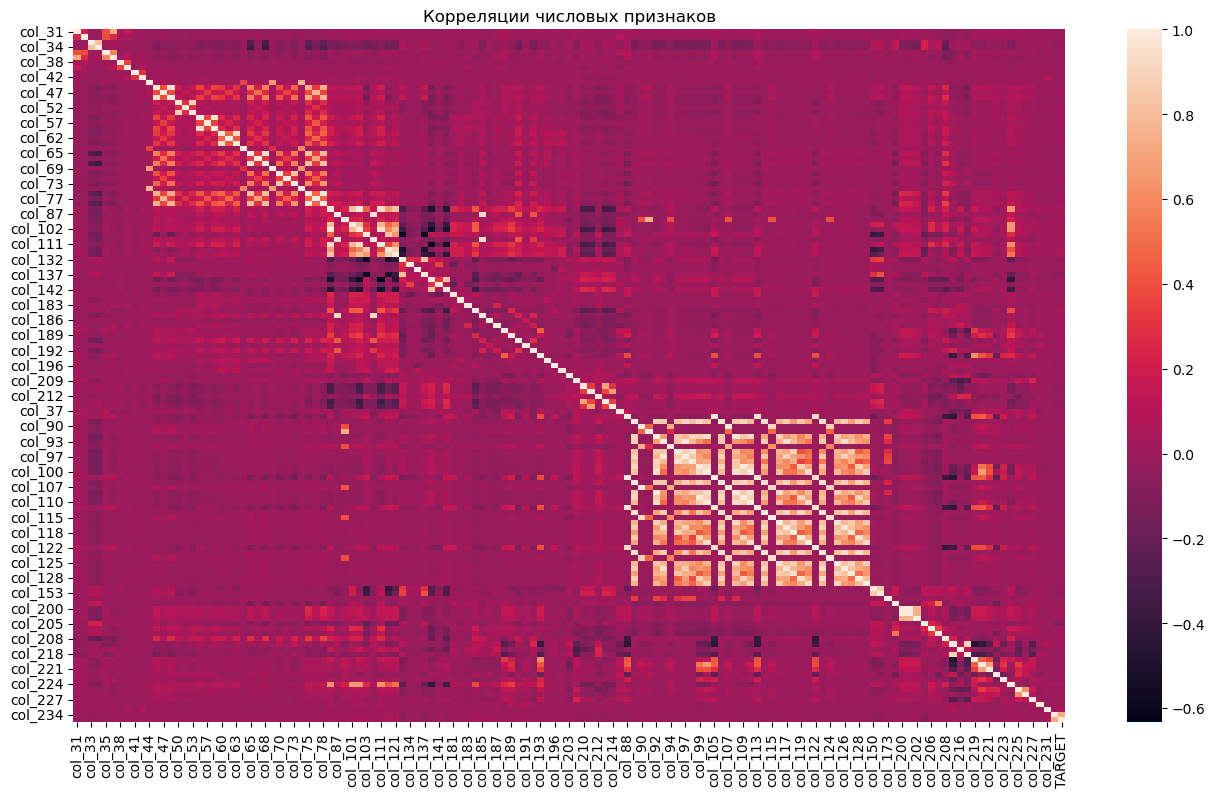

In [16]:
numerical_correlations = dataset.loc[:, numerical + ['TARGET']]
categorical_correlations = dataset.loc[:, categorical + ['TARGET']]

plt.figure(figsize=(16, 9))
sns.heatmap(data=numerical_correlations.corr(), square=False)
plt.title('Корреляции числовых признаков')
plt.show()

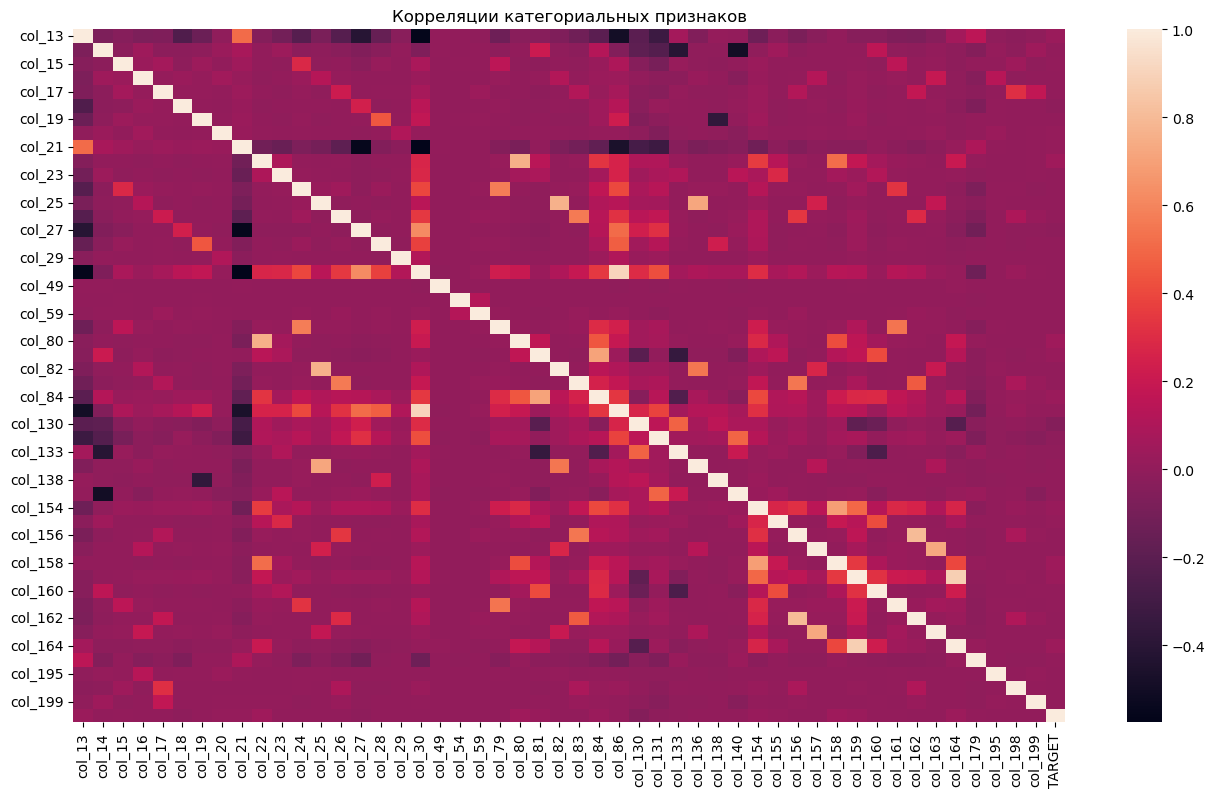

In [17]:
plt.figure(figsize=(16, 9))
sns.heatmap(data=categorical_correlations.corr(), square=False)
plt.title('Корреляции категориальных признаков')
plt.show()

Видна сильная корреляция между признаком `col_234` и целевой переменной.

## Разделите данные на train, val и test (5 баллов)

1. train для обучения

2. val для промежуточной оценки метрик

3. test - отложенная выборка для финальной оценки метрик

Для test строго используйте условие `OBSDATE >= "2023-11-01"`

In [20]:
preprocess = dataset.copy()
preprocess[categorical] = preprocess[categorical].astype('category')
preprocess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 187 entries, TARGET to col_234
dtypes: category(49), datetime64[us](1), float64(61), int64(76)
memory usage: 110.0 MB


In [22]:
train, test = preprocess[preprocess['OBSDATE'] <= "2023-11-01"], preprocess[preprocess['OBSDATE'] > "2023-11-01"]

X, y = train.drop(columns=['TARGET']), train['TARGET']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 37)
X_test, y_test = test.drop(columns=['TARGET']), test['TARGET']

In [25]:
print(f'Всего примеров в train: {len(X_train)}, всего примеров в test: {len(X_val)}', end='\n\n')

print(f'Распределение целевой переменной в train: {y_train.mean():.4f} ({(y_train==0).sum()}/{(y_train==1).sum()})')
print(f'Распределение целевой переменной в val: {y_val.mean().mean():.4f} ({(y_val==0).sum()}/{(y_val==1).sum()})')
print(f'Распределение целевой переменной в test: {y_test.mean().mean():.4f} ({(y_test==0).sum()}/{(y_test==1).sum()})')

Всего примеров в train: 65936, всего примеров в test: 16484

Распределение целевой переменной в train: 0.0176 (64778/1158)
Распределение целевой переменной в val: 0.0176 (16194/290)
Распределение целевой переменной в test: 0.0076 (17447/133)


Посмотрим на распределение некоторых признаков в разных частях датасета.

In [29]:
def draw_plots(feature):

    train = pd.concat([X_train, y_train], axis=1)
    val = pd.concat([X_val, y_val], axis=1)
    test = pd.concat([X_test, y_test], axis=1)
    
    figure, axes = plt.subplots(1, 3, figsize=(14, 4))

    for idx, (split, title) in enumerate(zip([train, val, test], ['Train Split', 'Val Split', 'Test Split'])):
        plt.subplot(1, 3, idx+1)
        plt.title(title)
        sns.kdeplot(data=split, x=feature, hue='TARGET', ax=axes[idx], fill=True, common_norm=False)
        plt.ylabel('')
    
    plt.show()

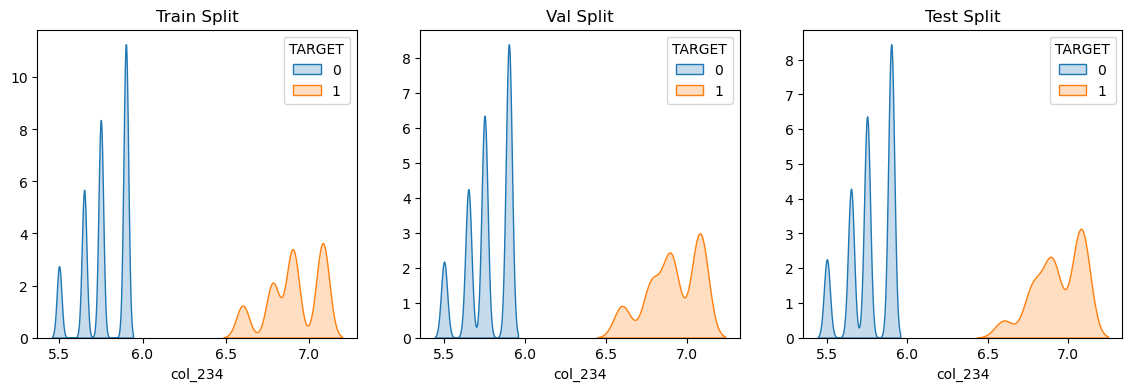

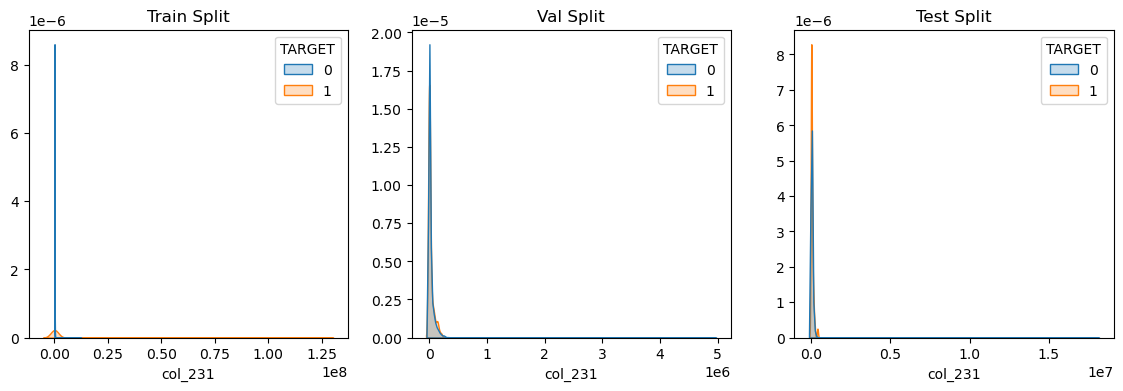

C:\Users\thunderpede\AppData\Local\Temp\ipykernel_8656\2462347631.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=split, x=feature, hue='TARGET', ax=axes[idx], fill=True, common_norm=False)


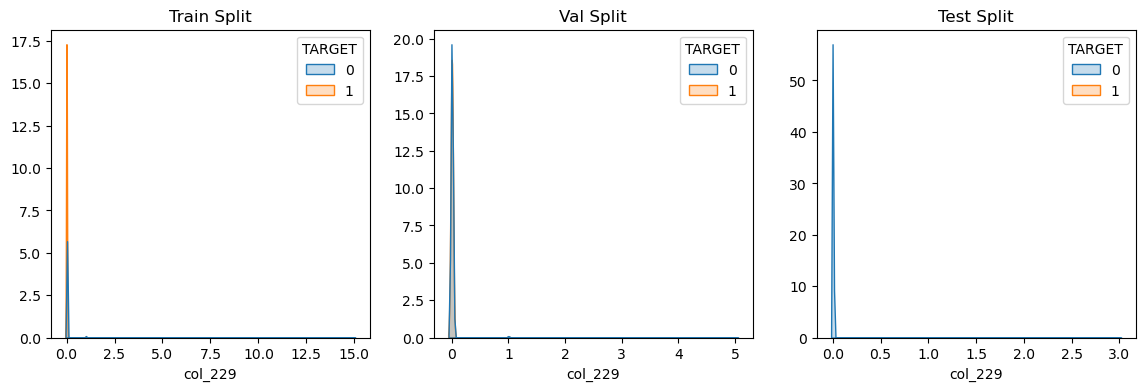

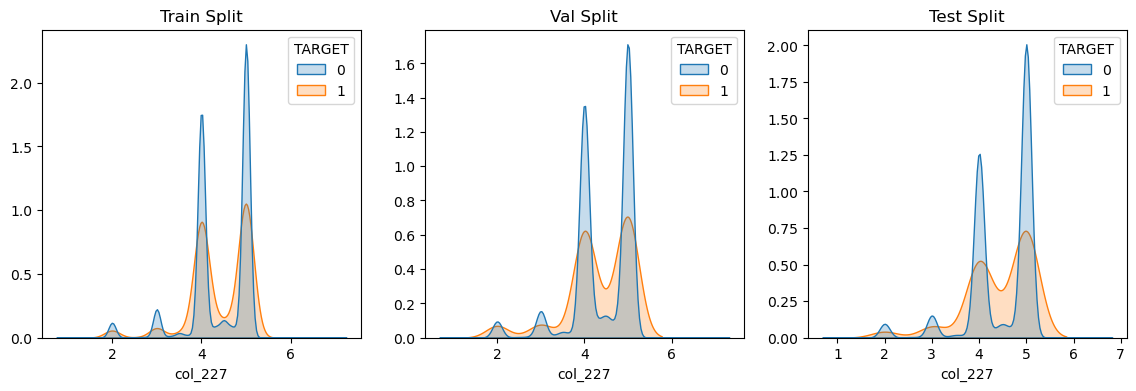

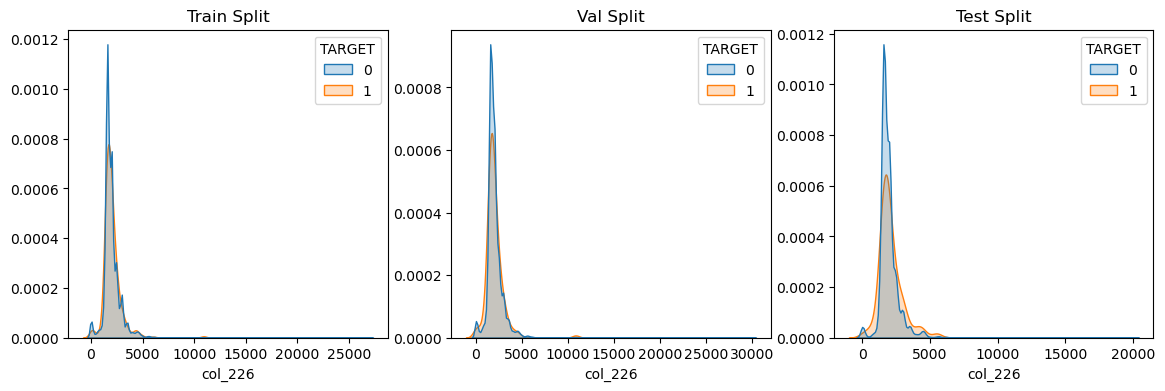

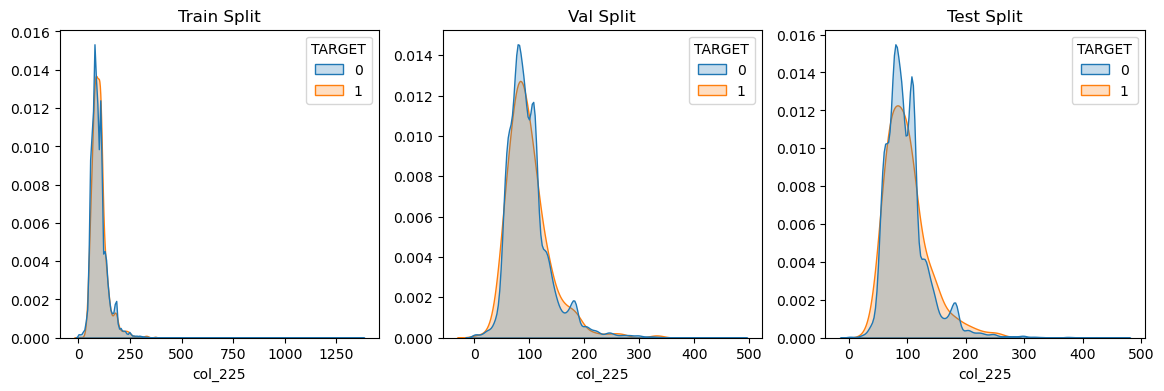

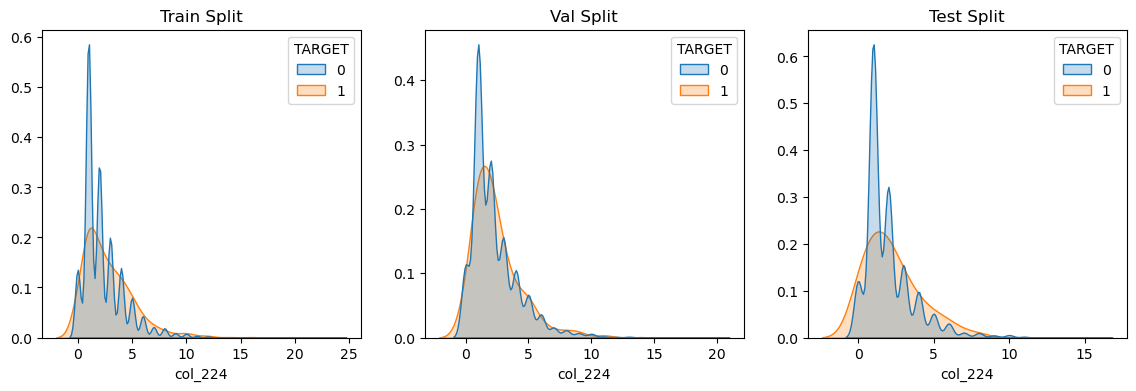

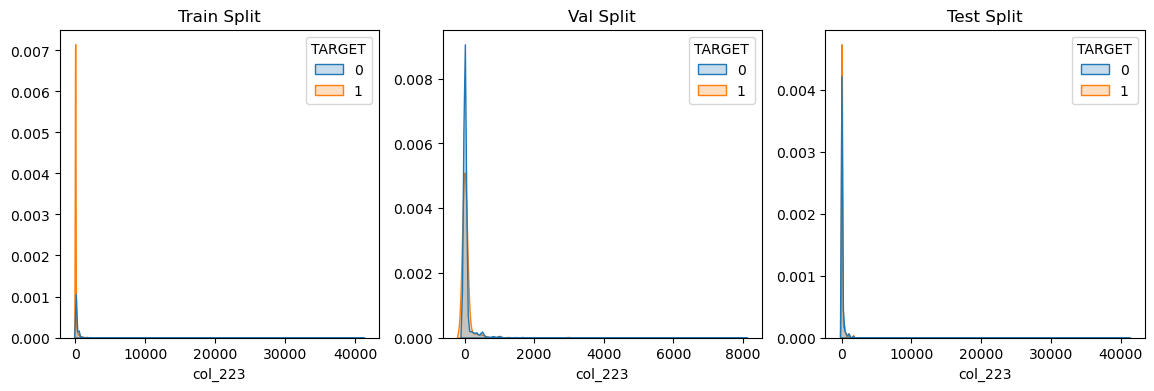

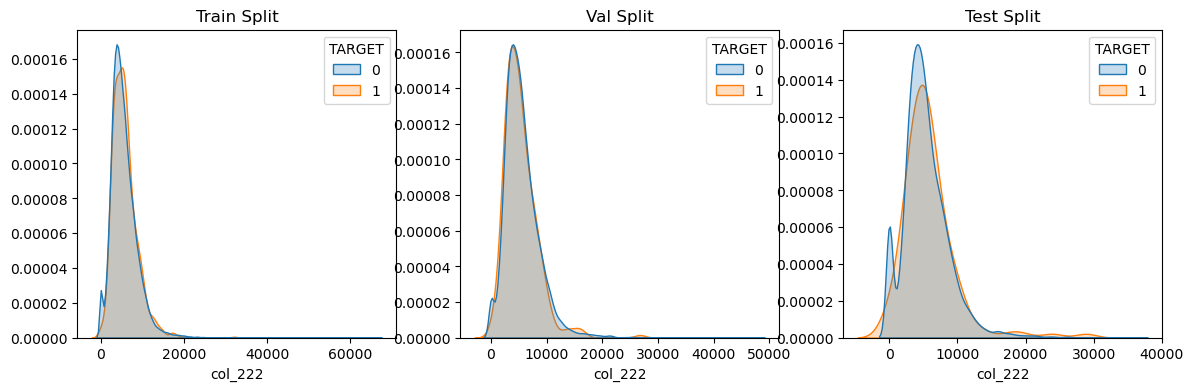

In [31]:
for feature in numerical[:-10:-1]:
    draw_plots(feature)

**Комментарий:** Признак `col_234` фактически повторяет целевую переменную. Если значение признака `[5.50; 5.90]` то `TARGET` = 0, а если `[6.60; 7.08]` то `TARGET` = 1.
Вероятно не стоит использовать этот признак в обучении моделей, поскольку этот признак имеет прямую зависимость с целевой переменной и отобран в датасет ошибочно.

Так же сразу поработаем над `OBSDATE`.

In [33]:
train, test = preprocess[preprocess['OBSDATE'] <= "2023-11-01"], preprocess[preprocess['OBSDATE'] > "2023-11-01"]

X, y = train.drop(columns=['TARGET', 'OBSDATE', 'col_234']), train['TARGET']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=37)
X_test, y_test = test.drop(columns=['TARGET', 'OBSDATE', 'col_234']), test['TARGET']

numerical.remove('col_234')

## Сэмплирование (20 баллов)

Примените к обучающей подвыборке оверсэмплинг (метод решения проблемы дисбаланса классов)

Рекомендуем воспользоваться `ADASYN` из imblearn.over_sampling, можете использовать другие методы на ваше усмотрение

In [35]:
undersampler = RandomUnderSampler(random_state=37)
upsampler = ADASYN(random_state=37)

**Комментарий:** в этой ячейке определил алгоритмы для undersampling и oversampling. Применять их к обучающим данным я буду в `imblearn.pipeline` обучения моделей, чтобы реализовать перебор гиперпараметров этих алгоритмов в `GridSearchCV`.

## Feature selection (15 баллов)
Отберите признаки для обучения модели.

Попробуйте отбирать разное количество N лучших признаков. 
Для отбора N лучших признаков можно попробовать несколько подходов: однофакторный анализ, мультиколлинеартность признаков, permutation importance и т.д.
Будет интересно найти оптимальное количество фичей (построить зависимость метрики качества от количества фичей), чтобы не использовать лишние фичи при обучении.

Подумайте:
Cтоит ли использовать для обучения признак, который слишком хорошо предсказывает TARGET?

Для обучения моделей и в том числе отбора признаков будет использоваться вспомогательная функция `trainer`.

In [538]:
def trainer(classificator, param_grid=None, selector=None, data_train=None, data_val=None, undersampler=None, upsampler=None, verbose=True,
           num_cols=None, cat_cols=None, cv=5, random_search_iter=None):

    categorical_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),  # Заполняем модой (можно "constant", fill_value="missing")
    ])
            
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('sampler', PolynomialFeatures())
    ])
    
    transformer = ColumnTransformer([
        ('numerical', numerical_pipeline, num_cols),
        ('categorical', categorical_pipeline, cat_cols),
    ], remainder='passthrough')

        
    pipeline = []
    pipeline.append(('transformer', transformer))
    pipeline.append(('selector', selector)) if selector else 'passthrough'
    pipeline.append(('undersampler', undersampler)) if undersampler else 'passthrough'
    pipeline.append(('upsampler', upsampler)) if upsampler else 'passthrough'
    pipeline.append(('classificator', classificator))

    pipeline = Pipeline(pipeline)

    if param_grid:
        model = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            scoring='f1',
            n_jobs=-1,
            refit=True,
            cv=cv,
            verbose=1,
            return_train_score=True)
    else:
        model = pipeline

    model.fit(*data_train)

    y_hat = model.predict(data_val[0])
    report = classification_report(data_val[1], y_hat, output_dict=True)
    
    if verbose:
        print(classification_report(data_val[1], y_hat), sep='\n')

        plt.figure(figsize=(5,5))
        sns.heatmap(confusion_matrix(data_val[1], y_hat), annot=True, fmt='', vmin=0, vmax=150, square=True)
        plt.xlabel('Prediction'), plt.ylabel('Ground truth')
        plt.show()
        
    return model, report

Построю график `f1-score` в зависимости от отобранных `features`. Зафиксирую значения сэмплирования. 

In [541]:
undersampler = RandomUnderSampler(sampling_strategy={0: 8000}, random_state=37)
upsampler = ADASYN(sampling_strategy={1: 3500}, random_state=37)

In [527]:
scores = {}

for N in tqdm(range(1, 184), leave=False):
    classificator = XGBClassifier(random_state=37, enable_categorical=True)
    selector = SelectKBest(score_func=f_classif, k=N)

    classificator, classificator_report = trainer(
        classificator=classificator,
        data_train=(X_train, y_train),
        data_val=(X_val, y_val),
        cat_cols=categorical,
        num_cols=numerical,
        selector=selector,
        undersampler=undersampler,
        upsampler=upsampler,
        verbose=False
    )

    scores[N] = classificator_report['1']['f1-score']

  0%|          | 0/183 [00:00<?, ?it/s]

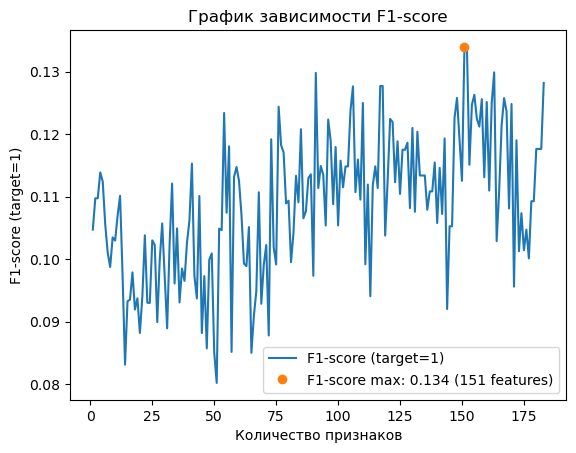

In [528]:
f1 = pd.Series(scores)

plt.title('График зависимости F1-score')
plt.plot(f1, label='F1-score (target=1)')
plt.plot(f1.idxmax(), f1.max(), 'o', label=f'F1-score max: {f1.max():.3f} ({f1.idxmax()} features)')

plt.xlabel('Количество признаков'), plt.ylabel('F1-score (target=1)')
plt.legend()

plt.show()

**Комментарий:** Однофакторный анализ показал, что оптимальное количество признаков = 151.

## Построение финальной модели, подсчет метрик и подбор гиперпараметров (15 + 10 баллов)

**Постройте бустинг (CatBoost, XGBoost, LightGBM) (10 баллов)**

**Оцените качество модели на (train, val, test) (5 баллов)**

**Подберите 4 гиперпараметра, используйте кросс-валидацию [Задание на доп баллы] (10 баллов)**

Выполню обучение с перебором параметров, в том числе с перебором параметров для `undersampler` и `upsampler`.

In [405]:
%%time

params = {
    'lambda': 10,
    'alpha': 0.5,
    'subsample': 0.7, 
    'colsample_bytree': 0.7,  
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 37,
    'enable_categorical': True
}


classificator = XGBClassifier(**params)

undersampler = RandomUnderSampler(random_state=37)
upsampler = ADASYN(random_state=37)

param_grid = {
    'upsampler__sampling_strategy': [{1: 3500}, 'auto'],
    'undersampler__sampling_strategy': [{0: 5000}],
    'classificator__max_depth': [3, 4],  
    'classificator__min_child_weight': [3, 5],
    'classificator__learning_rate': [0.05, 0.01],
    'classificator__gamma': [0.5, 1],
    'classificator__n_estimators': [100, 200]
}

xgb, xgb_report = trainer(
    classificator=classificator,
    param_grid=param_grid,
    undersampler=undersampler,
    upsampler=upsampler,
    data_train=(X_train, y_train),
    data_val=(X_val, y_val),
    cat_cols=categorical,
    num_cols=numerical,
    cv=5,
    verbose=False,
)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
CPU times: total: 16.3 s
Wall time: 1min 48s


In [406]:
xgb.best_estimator_

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['col_31', 'col_32', 'col_33',
                                                   'col_34', 'col_35', 'col_36',
                                                   'col_38', 'col_39', 'col_41',
                                                   'col_42', 'col_44', 'col_45',
                                                   'col_47', 'col_48', 'col_50',
                                                   'col_52', 'col_53', 'col_...
                               enable_categorical=True, eval_metric='logloss',
                               feature_types=None, gamma=1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, lambda=10,
                               learning_rate=0.05, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=4,
                               max_leaves=None, min_child_weight=5, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None, ...))])

In [407]:
print(classification_report(y_train, xgb.predict(X_train), digits=4), sep='\n')

              precision    recall  f1-score   support

           0     0.9879    0.9530    0.9702     64778
           1     0.1175    0.3497    0.1759      1158

    accuracy                         0.9424     65936
   macro avg     0.5527    0.6514    0.5730     65936
weighted avg     0.9727    0.9424    0.9562     65936



In [408]:
print(classification_report(y_val, xgb.predict(X_val), digits=4), sep='\n')

              precision    recall  f1-score   support

           0     0.9862    0.9504    0.9679     16194
           1     0.0843    0.2552    0.1267       290

    accuracy                         0.9381     16484
   macro avg     0.5352    0.6028    0.5473     16484
weighted avg     0.9703    0.9381    0.9531     16484



In [409]:
print(classification_report(y_test, xgb.predict(X_test), digits=4), sep='\n')

              precision    recall  f1-score   support

           0     0.9934    0.9738    0.9835     17447
           1     0.0419    0.1504    0.0656       133

    accuracy                         0.9676     17580
   macro avg     0.5177    0.5621    0.5245     17580
weighted avg     0.9862    0.9676    0.9766     17580



**Комментарий:** попытался сильно регуляризировать модель, чтобы на валидационной и тестовой выборке чуть подросло качество.

## Построение графиков (15 баллов)

Необходимо построить:

* Roc auc curve

* Precision recall curve

* Heatmap для матрицы ошибок 

In [415]:
def plot_results(model, X, y):
    y_prob = model.predict_proba(X)
    y_hat = model.predict(X)
    
    fpr, tpr, _ = roc_curve(y, y_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y, y_prob[:, 1])
    pr_auc = auc(recall, precision)  # AUC-PR (площадь под PR-кривой)

    figure, axes = plt.subplots(1, 3, figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Линия случайного угадывания
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()
    
    plt.subplot(1, 3, 3)
    sns.heatmap(confusion_matrix(y, y_hat), annot=True, fmt='', vmin=0, vmax=5000, square=True)
    plt.xlabel('Prediction'), plt.ylabel('Ground truth')

    plt.show()    

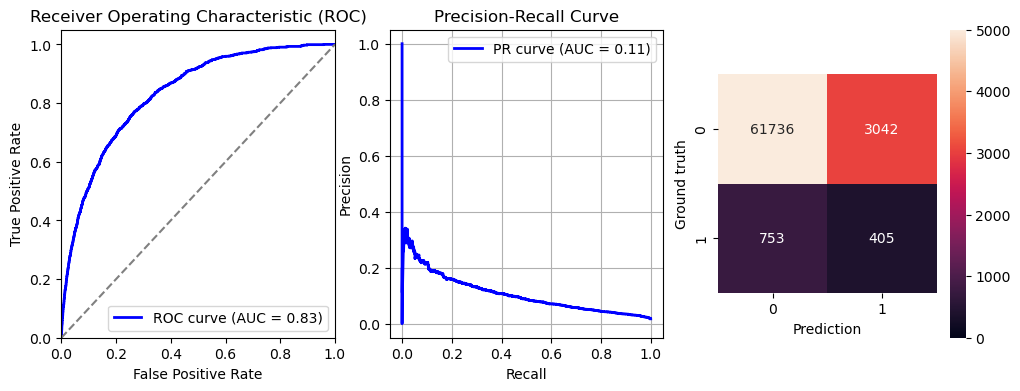

In [417]:
plot_results(xgb, X_train, y_train)

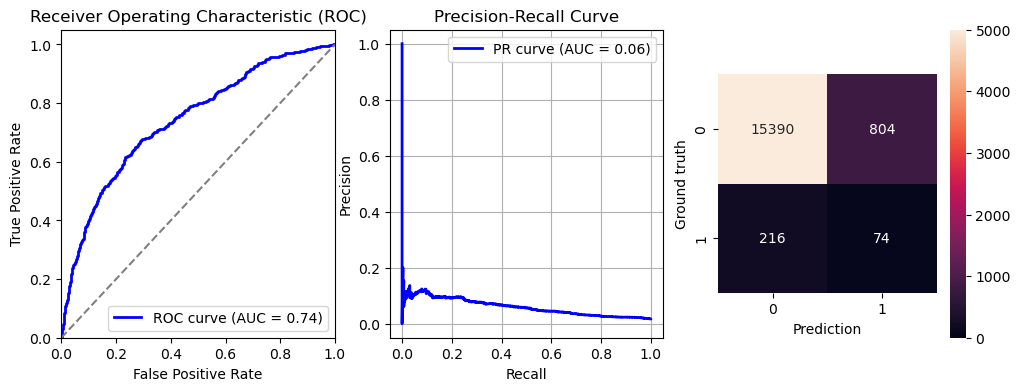

In [418]:
plot_results(xgb, X_val, y_val)

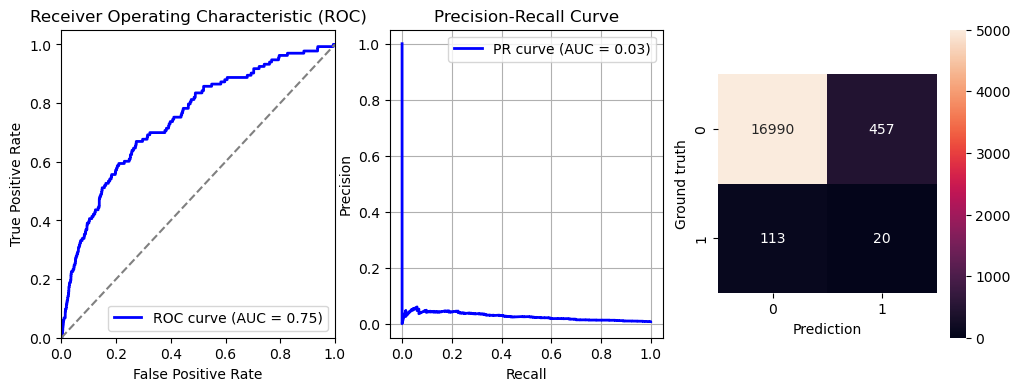

In [420]:
plot_results(xgb, X_test, y_test)

## Выделите ключевые признаки (10 баллов)
При помощи библиотеки shap выделите 5 самых важных признаков при построении модели

In [468]:
best_model = xgb.best_estimator_

estimator = best_model[-1]
transformer = best_model[-4]

In [470]:
X_transformed = transformer.transform(X_train)
X_transformed.shape

(65936, 184)

In [472]:
explainer = shap.Explainer(estimator, X_transformed)
shap_values = explainer(X_transformed)

100%|===================| 65892/65936 [02:38<00:00]        

In [484]:
shap_importance = np.abs(shap_values.values).mean(axis=0)

feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': shap_importance})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

Топ-5 ключевых признаков модели:

     feature  importance
117  col_139    0.341084
48    col_68    0.169336
16    col_29    0.108357
40    col_58    0.100992
72    col_94    0.081483


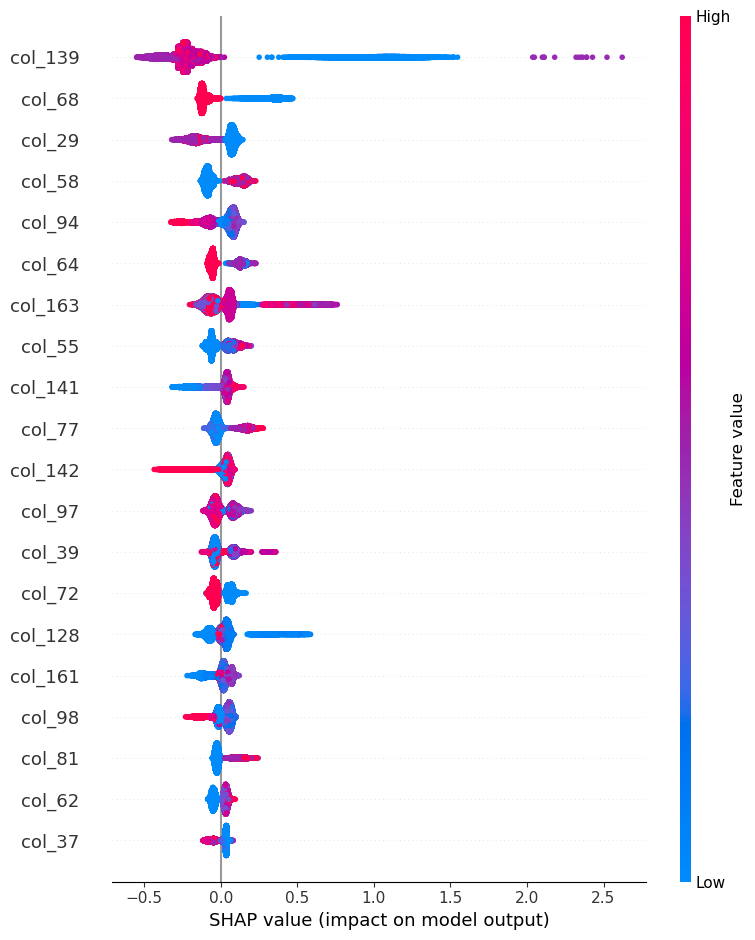

In [486]:
top_5_features = feature_importance.head(5)
print('Топ-5 ключевых признаков модели:', top_5_features, sep='\n\n')

shap.summary_plot(shap_values, X_transformed, feature_importance['feature'])

**Вывод**  

В целом по работе удалось выполнить все требуемые задания, в том числе GridSearchCV с перебором параметров модели и алгоритмов семплирования. Конечно, получилось очень маленькое качество без признака `col_234`. Возможно, стоит уделить внимание созданию дополнительных признаков.

Дополнительно проводил эксперименты с добавлением признака `OBSDATE` в обучающие данные. Это позволяет добавить качества к train и val части датасета, но на test, к сожалению, влияет обратным образом. Также эксперименитировал с созданием `PolynomialFeatures`, но тоже прироста также не получил.

Также пробовал обучать XGBoostRegressor на целевую переменную `col_234`, с дальнейшим использованием этого предсказания для определения `TARGET`, но безрезультатно.

Если не проводить сильную регуляризацию модели, то модель сильно переобучается на train часть с f1-score для класса `1` более 0.7, то есть модель способна из текущих признаков предсказывать `TARGET`, но на val и test всё очень плохо. 
